In [1]:
import itertools
from collections import defaultdict
from pathlib import Path

import os
import torch
import numpy as np
import pickle

import matplotlib.pyplot as plt
from matplotlib.ticker import FormatStrFormatter


from ase.io.vasp import read_vasp_xml
from ase.neighborlist import natural_cutoffs, NeighborList
from ase.io import read, Trajectory

from ase.db import connect

def write_pickle(filename, obj):
    with open(filename, 'wb') as f:
        pickle.dump(obj, f)

def read_pickle(filename):
    with open(filename, 'rb') as f:
        obj = pickle.load(f)
    return obj

def get_hr(traj, bins):
    """
    compute h(r) for MD17 simulations.
    traj: T x N_atoms x 3
    """
    pdist = torch.cdist(traj, traj).flatten()
    hist, _ = np.histogram(pdist[:].flatten().numpy(), bins, density=True)
    return hist

def get_thermo(filename):
    """
    read thermo logs.
    """
    with open(filename, 'r') as f:
        thermo = f.read().splitlines()
        sim_time, Et, Ep, Ek, T = [], [], [], [], []
        for i in range(1, len(thermo)):
            try:
                t, Etot, Epot, Ekin, Temp = [float(x) for x in thermo[i].split(' ') if x]
                sim_time.append(t)
                Et.append(Etot)
                Ep.append(Epot)
                Ek.append(Ekin)
                T.append(Temp)
            except:
                sim_time, Et, Ep, Ek, T = [], [], [], [], []
    thermo = {
        'time': sim_time,
        'Et': Et,
        'Ep': Ep,
        'Ek': Ek,
        'T': T
    }
    return thermo

def compute_image_flag(cell, fcoord1, fcoord2):
    supercells = torch.FloatTensor(list(itertools.product((-1, 0, 1), repeat=3))).to(cell.device)
    fcoords = fcoord2[:, None] + supercells
    coords = fcoords @ cell
    coord1 = fcoord1 @ cell
    dists = torch.cdist(coord1[:, None], coords).squeeze()
    image = dists.argmin(dim=-1)
    return supercells[image].long()

def frac2cart(fcoord, cell):
    return fcoord @ cell

def cart2frac(coord, cell):
    invcell = torch.linalg.inv(cell)
    return coord @ invcell

# the source data is in wrapped coordinates. need to unwrap it for computing diffusivity.
def unwrap(pos0, pos1, cell):
    fcoords1 = cart2frac(pos0, cell)
    fcoords2 = cart2frac(pos1, cell)
    flags = compute_image_flag(cell, fcoords1, fcoords2)
    remapped_frac_coords = cart2frac(pos1, cell) + flags
    return frac2cart(remapped_frac_coords, cell)

# different from previous functions, now needs to deal with non-cubic cells. 
def compute_distance_matrix_batch(cell, cart_coords, num_cells=1):
    pos = torch.arange(-num_cells, num_cells+1, 1).to(cell.device)
    combos = torch.stack(
        torch.meshgrid(pos, pos, pos, indexing='xy')
            ).permute(3, 2, 1, 0).reshape(-1, 3).to(cell.device)
    shifts = torch.sum(cell.unsqueeze(0) * combos.unsqueeze(-1), dim=1)
    # NxNxCells distance array
    shifted = cart_coords.unsqueeze(2) + shifts.unsqueeze(0).unsqueeze(0)
    dist = cart_coords.unsqueeze(2).unsqueeze(2) - shifted.unsqueeze(1)
    dist = dist.pow(2).sum(dim=-1).sqrt()
    # But we want only min
    distance_matrix = dist.min(dim=-1)[0]
    return distance_matrix

def get_rdf(data_seq, lattices, bins, device='cpu'):
    data_seq = data_seq.to(device).float()
    lattices = lattices.to(device).float()
    
    lattice_np = lattices.cpu().numpy()
    volume = float(abs(np.dot(np.cross(lattice_np[0], lattice_np[1]), lattice_np[2])))
    data_pdist = compute_distance_matrix_batch(lattices, data_seq)

    data_pdist = data_pdist.flatten().cpu().numpy()
    data_shape = data_pdist.shape[0]

    data_pdist = data_pdist[data_pdist != 0]
    data_hist, _ = np.histogram(data_pdist, bins)

    rho_data = data_shape / volume
    Z_data = rho_data * 4 / 3 * np.pi * (bins[1:] ** 3 - bins[:-1] ** 3)
    rdf = data_hist / Z_data

    return rdf

def mae(x, y, factor):
    return np.abs(x-y).mean() * factor

def load_run(md_dir, cell, xlim, bins, stability_threshold, gt_rdf, rdf_check_interval):
    if not isinstance(md_dir, Path):
        md_dir = Path(md_dir)
        
    run = {}

    run['traj'] = Trajectory(md_dir / 'atoms.traj')
    run['traj'] = torch.from_numpy(np.stack([run['traj'][i].positions 
                                                  for i in range(len(run['traj']))]))
    run['thermo'] = get_thermo( md_dir / 'thermo.log')

    T = np.array(run['thermo']['T']) 
    collapse_pt = len(T)
    rdf_mae_list = []
    for i in (range(1, len(T)-rdf_check_interval)):
        timerange = torch.arange(i, i + rdf_check_interval)
        current_rdf = get_rdf(run['traj'][timerange], cell, bins)
        rdf_mae = mae(current_rdf, gt_rdf, xlim)
        rdf_mae_list.append(rdf_mae)
        if rdf_mae > stability_threshold:
            collapse_pt = i
            break
    
    run['collapse_pt'] = collapse_pt

    return run

def get_traj_info(atoms):
    positions_list = []
    forces_mag_dict = defaultdict(list)
    for atom in atoms:
        forces = atom.get_forces()
        atomic_numbers = atom.get_atomic_numbers()
        positions = atom.get_positions()
        
        forces_mag = np.linalg.norm(forces, axis=-1)
        forces_mag1 = forces_mag[atomic_numbers == 1]
        forces_mag6 = forces_mag[atomic_numbers == 8]

        forces_mag_dict['atom1'].append(forces_mag1)
        forces_mag_dict['atom8'].append(forces_mag6)

        positions_list.append(positions)
    
    cell = atom.get_cell()

    forces_mag_atom1 = np.concatenate(forces_mag_dict['atom1'], axis=0)
    forces_mag_atom8 = np.concatenate(forces_mag_dict['atom8'], axis=0)

    return forces_mag_atom1, forces_mag_atom8, np.array(positions_list), cell

def force_mag_per_atom(atoms):
    forces_mag_dict = defaultdict(list)
    for atom in atoms:
        forces = atom.get_forces()
        atomic_numbers = atom.get_atomic_numbers()
        
        forces_mag = np.linalg.norm(forces, axis=-1)
        forces_mag1 = forces_mag[atomic_numbers == 1]
        forces_mag8 = forces_mag[atomic_numbers == 8]

        forces_mag_dict['atom1'].append(forces_mag1)
        forces_mag_dict['atom8'].append(forces_mag8)

    forces_mag_atom1 = np.concatenate(forces_mag_dict['atom1'], axis=0)
    forces_mag_atom8 = np.concatenate(forces_mag_dict['atom8'], axis=0)

    return forces_mag_atom1, forces_mag_atom8

# Read ground truth and predicted trajectories

In [2]:
# You should modify data_dir and model_dir
data_dir = '/scratch/yangzd/materials/data/md/H2O'
data_path = os.path.join(data_dir, 'vasprun.xml') # data path

model_dir = './wandb/run-20231123_114816-LEIGNN_20231123_114814'
md_dir = os.path.join(model_dir, 'md') # model dir

configs = read_vasp_xml(data_path, index=slice(None)) # read xml
forces_mag_H_dft, forces_mag_O_dft, positions, cell = get_traj_info(configs) 
write_pickle(os.path.join(md_dir, 'traj_info.pkl'), (forces_mag_H_dft, forces_mag_O_dft, positions, cell)) # save traj information

forces_mag_H_dft, forces_mag_O_dft, positions, cell = read_pickle(os.path.join(md_dir, 'traj_info.pkl')) # read traj information
gt_positions = torch.from_numpy(positions) # ground truth positions
cell = torch.from_numpy(np.array(cell)).float() 

pred_traj = Trajectory(os.path.join(md_dir, 'atoms.traj'))
pred_positions = torch.Tensor([x.positions for x in pred_traj]) # predicted positions
forces_mag_H_ml, forces_mag_O_ml = force_mag_per_atom(pred_traj) # predicted force magnitude

/tmp/ipykernel_3162018/3653693049.py:17: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at /opt/conda/conda-bld/pytorch_1670525551200/work/torch/csrc/utils/tensor_new.cpp:230.)
  pred_positions = torch.Tensor([x.positions for x in pred_traj]) # predicted positions


# Ploting force magnitude

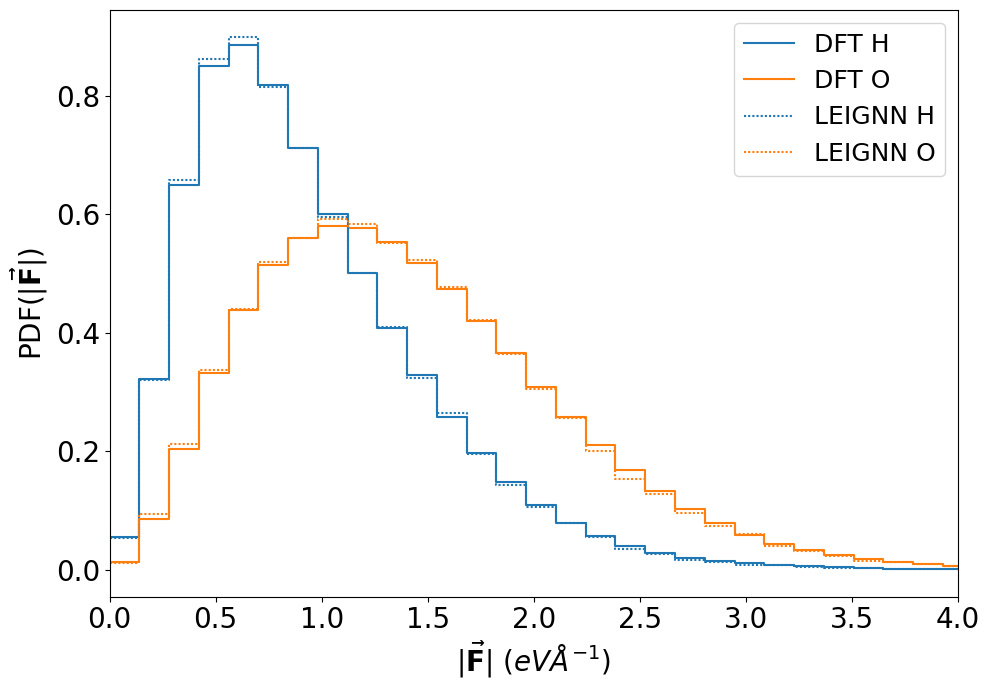

In [3]:

# Define colors for each atom type
colors = {'H': '#1f77b4', 'O': '#ff7f0e'}  # colors from the "tab10" palette

# Define labels and line styles for each method
method_specs = {'DFT': {'label': 'DFT', 'linestyle': '-'}, 'ML': {'label': 'LEIGNN', 'linestyle': (0, (1, 1))}}

# Define bins for histogram
bins = np.linspace(0, max(np.max(forces_mag_H_dft), np.max(forces_mag_O_dft)), 60)

# Create the plot
fig, ax = plt.subplots(figsize=(10, 7))

# Calculate and plot histograms
for method, forces in zip(['DFT', 'ML'], [[forces_mag_H_dft, forces_mag_O_dft],
                                          [forces_mag_H_ml, forces_mag_O_ml]]):
    for atom_type, force in zip(['H', 'O'], forces):
        hist, bin_edges = np.histogram(force, bins=bins, density=True)
        ax.step(bin_edges[:-1], hist, where='post', color=colors[atom_type], 
                label=f'{method_specs[method]["label"]} {atom_type}', linestyle=method_specs[method]['linestyle'], lw=1.5)


ax.set_xlabel(r'$\vert \mathbf{\vec{F}} \vert$ ($eV\AA^{-1}$)', fontsize=20)
ax.set_ylabel(r'PDF($\vert \mathbf{\vec{F}} \vert$)', fontsize=20)
ax.legend(fontsize=18, loc='upper right')
ax.set_xlim(0, 4)  # Set the x-axis limits
ax.tick_params(axis='both', which='major', labelsize=20)
plt.tight_layout()
plt.show()
# plt.savefig(os.path.join(md_dir, "force_pdf.jpg"), dpi=400)

# Evaluate the stability

In [4]:
stability_threshold = 1.0 # for water
rdf_check_interval = 40
xlim = 6
nbins = 500
bins = np.linspace(1e-6, xlim, nbins + 1)
gt_rdf = get_rdf(gt_positions[::20], cell, bins)
run = load_run(md_dir, cell, xlim, bins, stability_threshold, gt_rdf, rdf_check_interval)
stability = int((run['collapse_pt'] - 1) * 50 * 0.5 / 1000)
print(f"stability: {stability} ps")

stability: 50 ps


# Computing h(r)

mae of h(r):  0.021372317851700316


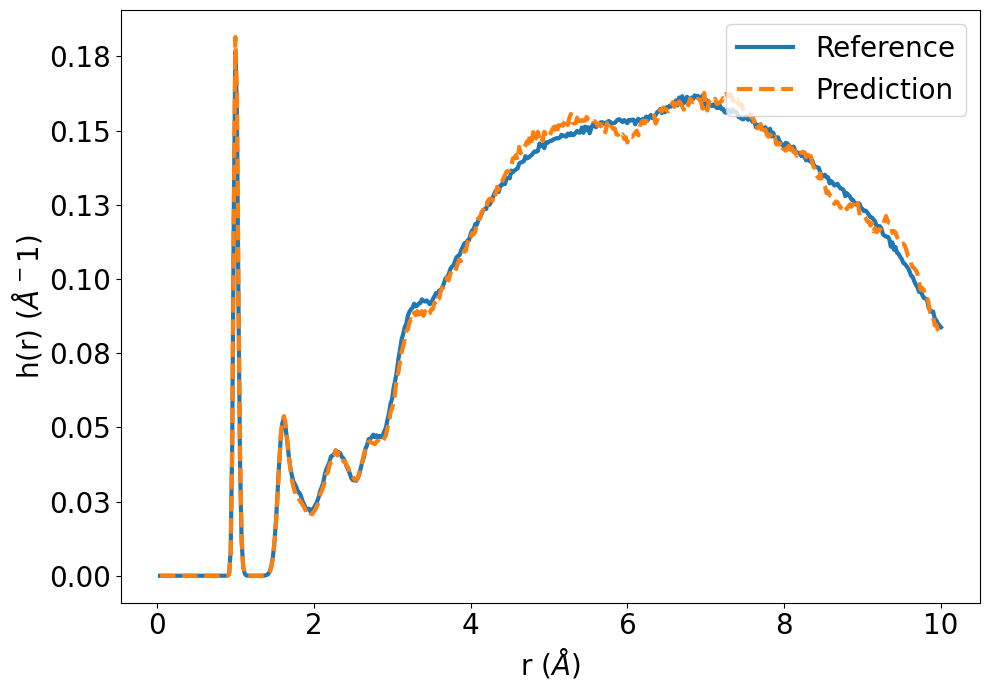

In [5]:
xlim = 10
n_bins = 500
bins = np.linspace(1e-6, xlim, n_bins + 1) # for computing h(r)

gt_hist = get_hr(gt_positions[::20], bins)
pred_positions = torch.Tensor([x.positions for x in Trajectory(os.path.join(md_dir, 'atoms.traj'))])
pred_hist = get_hr(pred_positions, bins)

fig, ax = plt.subplots(figsize=(10, 7))
plt.plot(bins[2:], gt_hist[1:], label='Reference', linewidth=3, linestyle='-', c='#1f77b4')
plt.plot(bins[2:], pred_hist[1:], label='Prediction', linewidth=3, linestyle='--', c='#ff7f0e')
ax.tick_params(axis='both', which='major', labelsize=20)
ax.set_xlabel(r'r ($\AA$)', fontsize=20)
ax.set_ylabel(r'h(r) ($\AA^-1$)', fontsize=20)

# Format y-axis to have two decimal places
ax.yaxis.set_major_formatter(FormatStrFormatter('%.2f'))
plt.legend(fontsize=20, loc='upper right')
plt.tight_layout()
# plt.show()
plt.savefig(os.path.join(md_dir, "hr.jpg"), dpi=400)
hr = mae(gt_hist[1:], pred_hist[1:], xlim)
print("mae of h(r): ", hr)

# Computing RDF

0.18990143014437455
mae of RDF:  0.18990143014437455


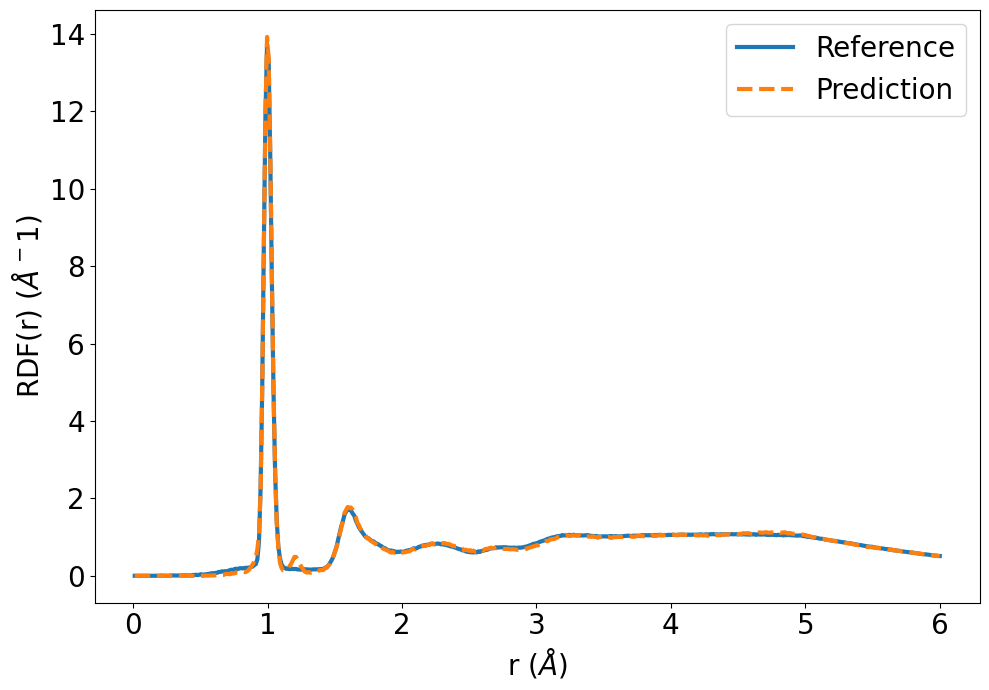

In [6]:
xlim = 6
nbins = 500
bins = np.linspace(1e-6, xlim, nbins + 1)
gt_rdf = get_rdf(gt_positions[::20], cell, bins)
pred_rdf = get_rdf(pred_positions, cell, bins)
rdf_mae = mae(pred_rdf, gt_rdf, xlim)
print(rdf_mae)

fig, ax = plt.subplots(figsize=(10, 7))
plt.plot(bins[1:], gt_rdf, label='Reference', linewidth=3, linestyle='-', c='#1f77b4')
plt.plot(bins[1:], pred_rdf, label='Prediction', linewidth=3, linestyle='--', c='#ff7f0e')
ax.tick_params(axis='both', which='major', labelsize=20)
ax.set_xlabel(r'r ($\AA$)', fontsize=20)
ax.set_ylabel(r'RDF(r) ($\AA^-1$)', fontsize=20)
plt.legend(fontsize=20, loc='upper right')
plt.tight_layout()
# plt.show()
plt.savefig(os.path.join(md_dir, "rdf.jpg"), dpi=400)
rdf_mae = mae(pred_rdf, gt_rdf, xlim)
print("mae of RDF: ", rdf_mae)